In [27]:
from header import *

D = 10


# model2 = copy.deepcopy(model1)
# model3 = copy.deepcopy(model1)
# model4 = copy.deepcopy(model1)

# set_seed(3342432)
# X = np.random.randn(D**2,D**2)
# X = X.reshape(D,D,D,D)
# X = X + X.transpose(1,0,3,2)
# X = X.reshape(D**2,D**2)
# X = (X + X.T)/2
model = nsp.model.UnitaryRiemanGenerator(D, dtype=torch.float64)
model.reset_params()
X1 = model.matrix().data.numpy() @ np.diag(np.random.rand(10)) @ model.matrix().data.numpy().T
model.reset_params()
X2 = model.matrix().data.numpy() @ np.diag(np.random.rand(10)) @ model.matrix().data.numpy().T
X = np.kron(X1, X2)
# model1 = nsp.model.UnitaryRiemanGenerator(D, dtype=torch.float64)


In [33]:
model2 = nsp.model.UnitaryRiemanGenerator(D, dtype=torch.float64)
model3 = nsp.model.UnitaryRiemanGenerator(D, dtype=torch.float64)
model4 = nsp.model.UnitaryRiemanGenerator(D, dtype=torch.float64)
# model = copy.deepcopy(model1)
model1 = copy.deepcopy(model)
# model2 = copy.deepcopy(model1)
# model3 = copy.deepcopy(model1)
# model4 = copy.deepcopy(model1)


loss = nsp.loss.MES(torch.Tensor(X), [D,D], inv = model1._inv)
loss1 = nsp.loss.MES(torch.Tensor(X)/3, [D,D], inv = model1._inv)
cg1 = RiemanUnitaryCG(model, loss, lr = 0.1)
cg2 = RiemanUnitaryCG2([(model1, model2), (model2, model3), (model3, model1)], [loss1]*3)

solver1 = UnitarySymmTs(RiemanUnitaryCG, model, loss, lr = 0.1)
solver2 = UnitaryLocalTs(cg2)

number of models is :  3


In [ ]:
ret_cg = solver1.run(200, disable_message=False)

In [34]:
ret_cg = solver2.run(200, disable_message=False)

dtype changes from torch.float32 to torch.float64
dtype changes from torch.float64 to torch.float32
target loss      : 0.8545545340
initial loss     : 1.1934226192
loss upper bound : 1.2893437743




  0%|          | 0/200 [00:00<?, ?it/s]

dtype changes from torch.float32 to torch.float64


In [52]:
cg2.loss_val().backward()
with torch.no_grad():
    inv_list = [cg2._riemannian_grad(model.params, model) for model in cg2.models]
    
def objective(t):
    U_list = []
    for H, U in inv_list:
        U_list.append(torch.matrix_exp(-t*H)@U)
    return cg2.loss_val(U_list)
print("{:.10f}".format(objective(0).item()))
cg2.step()
t =  torch.tensor([0], requires_grad=True, dtype=torch.float64)
loss = objective(t)
g = torch.autograd.grad(loss, t, create_graph=True)
loss.item(), g[0].item()

0.9360763181


(0.9360763181195371, -0.028000151238040883)

In [55]:
cg2._golden(inv_list)

0.0009274634328168228

In [58]:
t_list = np.linspace(-100, 100, 1000)
res_grad = []
res = []
for t_ in t_list:
    t =  torch.tensor([t_], requires_grad=True, dtype=torch.float64)
    loss = objective(t)
    g = torch.autograd.grad(loss, t, create_graph=True)
    res.append(loss.item())
    res_grad.append(g[0].item())    

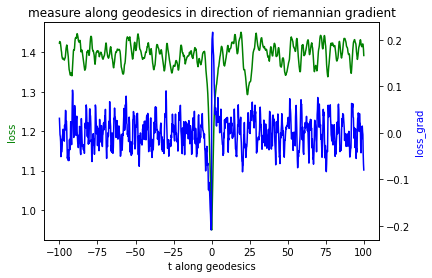

In [59]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_title('measure along geodesics in direction of riemannian gradient')
ax1.set_xlabel('t along geodesics')
ax1.set_ylabel('loss', color='g')
ax2.set_ylabel('loss_grad', color='b')
ax1.plot(t_list, res, color="g")
ax2.plot(t_list, res_grad, color="b")

In [1]:
from header import *

D = 10
set_seed(3342432)
X = np.random.randn(D**2,D**2)

X = (X + X.T)/2
E, V = np.linalg.eigh(X)
P = np.diag(np.sign(V[:,-1]))
model = nsp.model.UnitaryRiemanGenerator(D, dtype=torch.float64)
model.reset_params()
loss = nsp.loss.MES(torch.Tensor(P @ X @ P), [D,D], inv = model._inv)
# loss = nsp.loss.MES(torch.Tensor(X), [D,D], inv = model._inv)

In [14]:
loss = nsp.loss.MES(torch.Tensor(X), [D,D], inv = model._inv)
solver1 = UnitarySymmTs(RiemanUnitaryCG, model, loss, lr = 0.1)
ret_cg = solver1.run(1000, disable_message=False)

dtype changes from torch.float32 to torch.float64
target loss      : 26.6965999603
initial loss     : 68.9246113905




  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
(model._params.grad)

tensor([ 1.9903, -6.2909, -7.8006, -3.1905], dtype=torch.float64)